In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as pp
import seaborn as sb

import numpy as np
import pandas as pd

import bambi as bm
import pymc as pm
import preliz as pz

In [2]:
data_path =  '../data/simple/advertisement_clicks.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,advertisement_id,action
0,B,1
1,B,1
2,A,0
3,B,0
4,A,1


In [5]:
df.groupby('advertisement_id').sum()

,action
advertisement_id,
A,304
B,372


In [6]:
adv_idx, adv = df.advertisement_id.factorize(sort=True)

In [7]:
coords = {
    'advert': adv,
    'obs_idx': df.index
}

In [8]:
with pm.Model(coords=coords) as m1:
    
    p = pm.Beta('p', 3, 3, dims='advert')
    _ = pm.Bernoulli('y', p=p[adv_idx], observed=df.action, dims='obs_idx')
    rel_uplift = pm.Deterministic('Relative Uplift (%)', (p[1] / p[0] - 1) * 100)

In [9]:
with m1:
    idata = pm.sample(chains=4, draws=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


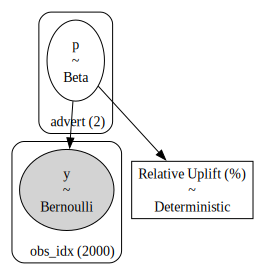

In [10]:
m1.to_graphviz()

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

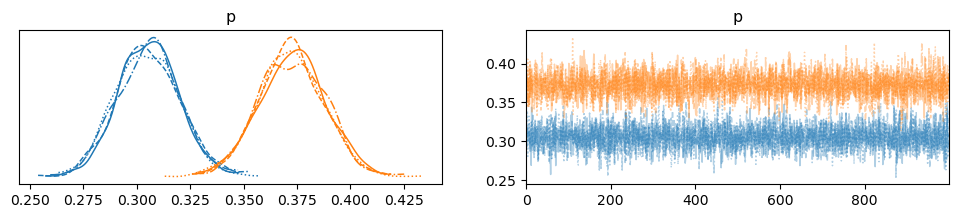

In [ ]:
az.plot_trace(idata, var_names='p', )

In [17]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [20]:
idata.posterior['p'].sel(advert='A').mean(('chain', 'draw'))

<xarray.DataArray 'p' ()> Size: 8B
array(0.30502245)
Coordinates:
    advert   <U1 4B 'A'

Text(0.5, 1.0, 'p(B)')

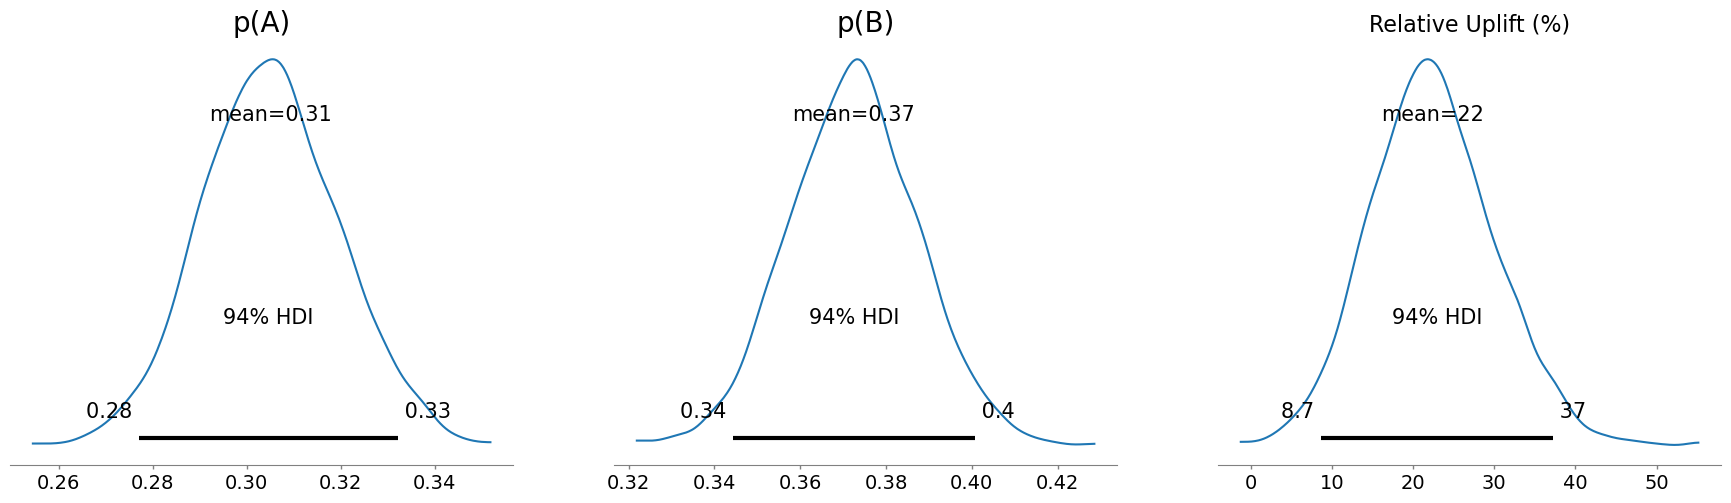

In [ ]:
axs = az.plot_posterior(idata, )
axs[0].set_title('p(A)', fontsize=20)
axs[1].set_title('p(B)', fontsize=20)

In [11]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

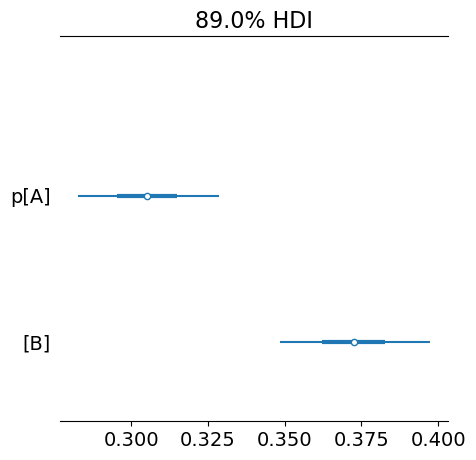

In [31]:
hdi_prob = 0.89
f, ax = pp.subplots(figsize=(5, 5))
az.plot_forest(idata, ax=ax, hdi_prob=hdi_prob, combined=True, var_names='p')

<Axes: title={'center': 'Relative Uplift (%)'}>

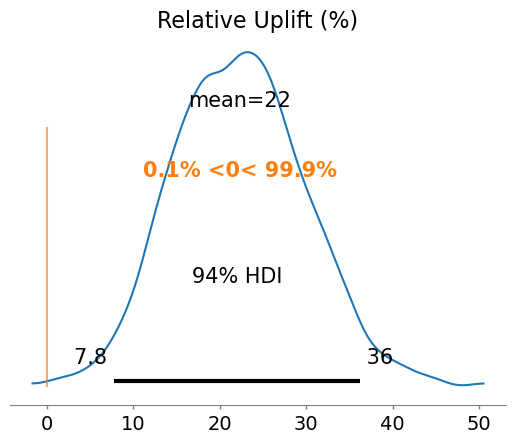

In [32]:
az.plot_posterior(idata, var_names='Relative Uplift (%)', ref_val=0)

In [68]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [33]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[A],0.305,0.015,0.277,0.331,0.000,0.000,3887.0,2646.0,1.0
p[B],0.372,0.015,0.342,0.400,0.000,0.000,3410.0,2626.0,1.0
Relative Uplift (%),22.308,7.746,7.760,36.232,0.125,0.092,3828.0,2904.0,1.0


### With Bambi

In [43]:
priors = {"advertisement_id": bm.Prior("Beta", alpha=1, beta=1)}
#extra_var = {'Relative Uplift (%)': }
model = bm.Model(
    "action ~ 0 +  advertisement_id", 
    df, 
    family="bernoulli",  
    link="identity", 
    priors=priors, 
)
idata_bambi = model.fit(chains=4, random_seed=1234)

Modeling the probability that action==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [advertisement_id]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [44]:
model

       Formula: action ~ 0 +  advertisement_id
        Family: bernoulli
          Link: p = identity
  Observations: 2000
        Priors: 
    target = p
        Common-level effects
            advertisement_id ~ Beta(alpha: 1.0, beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

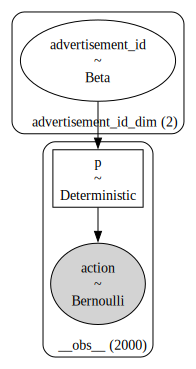

In [45]:
model.graph()

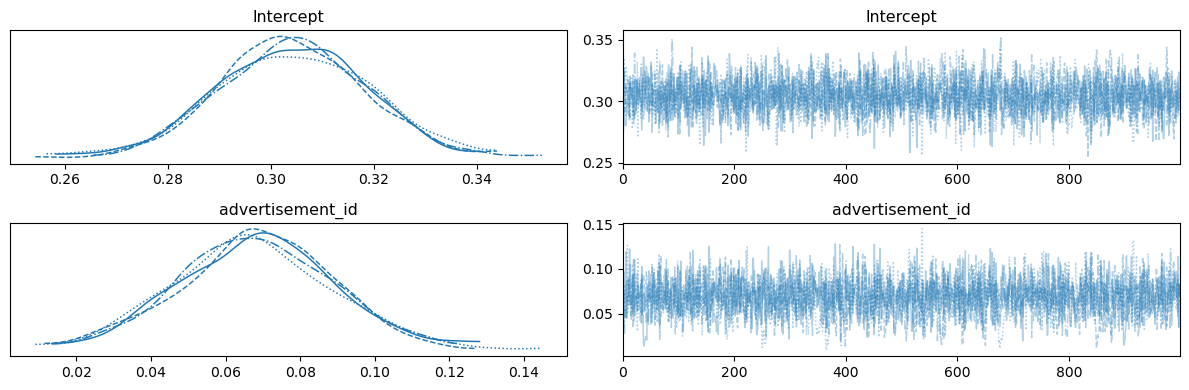

In [39]:
az.plot_trace(idata_bambi, backend_kwargs={'tight_layout': True});

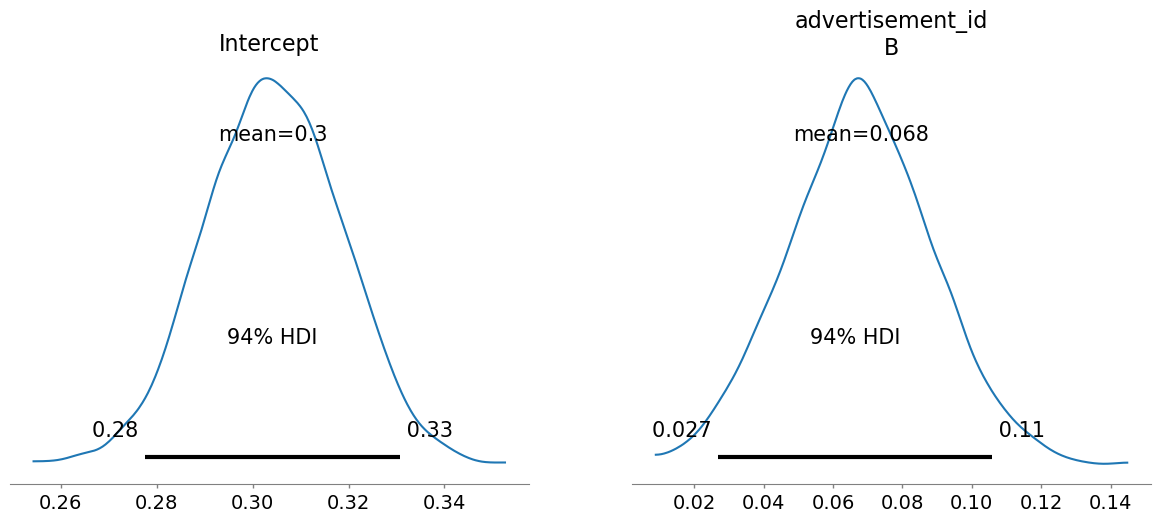

In [41]:
az.plot_posterior(idata_bambi);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

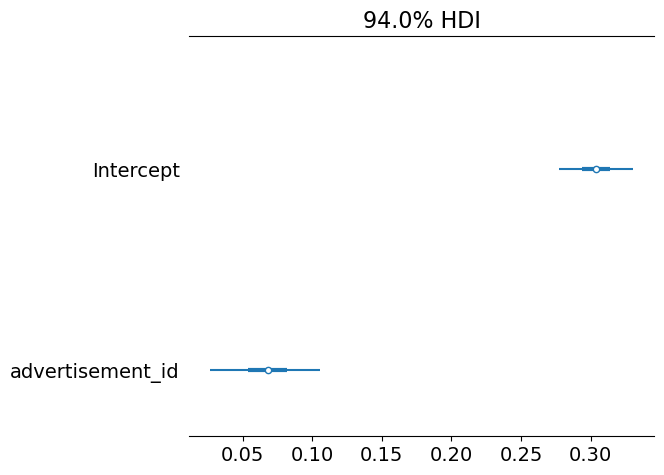

In [42]:
az.plot_forest(idata_bambi, combined=True)